In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout    
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten

In [2]:
def split_dataset(
                data_path = 'data/data_v2.csv',
                customer_locs = [
                                'Mokki Rautalampi', 
                                'kuokkalanpelto', 
                                'sarvivuori',
                                'kotiranta',
                                'Keljo'
                                ],
                preprocessed_dir = 'data/processed/',
                ):
    df = pd.read_csv(data_path, low_memory=False)
 
    
    for loc in customer_locs:
        df_loc = df[df['Customer_Location'] == loc]
        location_path = preprocessed_dir + loc + '.csv'
        if not os.path.exists(location_path):
            df_loc.to_csv(
                        location_path, 
                        index=False
                        )

In [3]:
split_dataset()

In [7]:
def preprocess_location_data(
                            location_name,
                            preprocessed_dir = 'data/processed/',
                            features_dir = 'features/',
                            output_column = "Quantity", 
                            selective_window = 30 * 24,
                            predictive_window = 7 * 24,
                            ):
    # Create features directory if it doesn't exist
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)
    
    # Define feature file paths
    feature_file = f"{features_dir}{location_name}.npz"
    
    # Check if features already exist
    if os.path.exists(feature_file):
        print(f"Loading preprocessed features from {feature_file}")
        data = np.load(feature_file)
        Xtrain, Ytrain, Xtest, Ytest = data['Xtrain'], data['Ytrain'], data['Xtest'], data['Ytest']

    else:
        print(f"Processing data for {location_name} and saving to {feature_file}")
        df = pd.read_csv(preprocessed_dir + location_name + '.csv', low_memory=False)
        df = df.drop(columns=['Customer_Location'])
        df.replace([np.inf, -np.inf, '-'], 0, inplace=True)

        # Check NaN value distribution
        print("======= BEFORE PREPROCESSING ======")
        nan_counts = df.isna().sum()
        print(nan_counts)

        # Fill NaN values with 0
        df.replace([np.inf, -np.inf, '-'], 0, inplace=True)
        df = df.fillna(0)

        print("\n======= AFTER PREPROCESSING ======")
        nan_counts = df.isna().sum()
        print(nan_counts)

        X, Y = [], []

        for i in range(len(df) - selective_window - predictive_window):
            X.append(df.iloc[i:i+selective_window].values)
            Y.append(df.iloc[i+selective_window:i+selective_window+predictive_window][output_column].values)

        X = np.array(X).astype(np.float32)
        Y = np.array(Y).astype(np.float32)

        scalar = MinMaxScaler()
        X = scalar.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

        # Check if we have enough data points after filtering
        if len(X) == 0:
            raise ValueError(f"Not enough data points after applying selective_window={selective_window} and preprocess_window={predictive_window}")

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                        X, Y, 
                                                        test_size=0.2, 
                                                        random_state=42
                                                        )
        
        # Save features to file
        np.savez(feature_file, Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest)
        print(f"Features saved to {feature_file}")

    return Xtrain, Ytrain, Xtest, Ytest


In [5]:
# Xtrain, Ytrain, Xtest, Ytest = preprocess_location_data('Mokki Rautalampi')

# print(f"Xtrain Shape : {Xtrain.shape}")
# print(f"Ytrain Shape : {Ytrain.shape}")
# print(f"Xtest Shape : {Xtest.shape}") 
# print(f"Ytest Shape : {Ytest.shape}")

In [6]:
def build_network(
                n_features,
                model_name,
                selective_window,
                predictive_window
                ):

        model = Sequential()
        
        # First Conv1D layer
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', 
                         input_shape=(selective_window, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))
        
        # Second Conv1D layer
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))
        
        # Third Conv1D layer
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
        model.add(Dropout(0.2))
        
        # Global pooling to reduce dimensions before Dense layers
        model.add(GlobalAveragePooling1D())
        
        # Dense layers remain the same
        model.add(Dense(32, activation='relu'))
        model.add(Dense(predictive_window, activation='linear'))
        
        model.compile(
                        optimizer='adam', 
                        loss='mse', 
                        metrics=[
                                'mae',
                                'mse'
                                ]
                        )
        
        print(f"\n=== {model_name} Architecture ===")
        model.summary()
        
        return model

In [7]:
# model = build_network(
#                     model_name='Conv1D Model', 
#                     n_features=Xtrain.shape[2], 
#                     selective_window=Xtrain.shape[1],
#                     predictive_window=Ytrain.shape[1]
#                     )

In [8]:
def e2e_pipeline(
                location_name,
                epochs=100, batch_size=64
                ):
    print("\n===================== Model for {} =====================".format(location_name))
    Xtrain, Ytrain, Xtest, Ytest = preprocess_location_data(location_name)
    print(f"Xtrain Shape : {Xtrain.shape}")
    print(f"Ytrain Shape : {Ytrain.shape}")
    print(f"Xtest Shape : {Xtest.shape}") 
    print(f"Ytest Shape : {Ytest.shape}")

    model = build_network(
                        model_name=location_name, 
                        n_features=Xtrain.shape[2], 
                        selective_window=Xtrain.shape[1],
                        predictive_window=Ytrain.shape[1])
    history = model.fit(
                        Xtrain, 
                        Ytrain, 
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(Xtest, Ytest)
                        )
    model.save(f"artifacts/conv1d/{location_name}.h5")

    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(3, 1, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae']) 
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(3, 1, 3)
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.savefig(f"vis/conv1d/{location_name}.png")
    plt.close()

In [9]:
# customer_locs = [
#                 'Mokki Rautalampi', 
#                 'kuokkalanpelto', 
#                 'sarvivuori',
#                 'kotiranta',
#                 'Keljo'
#                 ]

# for loc in customer_locs:
#     e2e_pipeline(loc)

In [10]:
e2e_pipeline('Mokki Rautalampi')


===================== Model for Mokki Rautalampi =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                 69
Maximum wind speed [m/s]         69
Average wind direction [°]       69
Maximum gust speed [m/s]         69
Precipitation [mm]                0
Average air pressure [hPa]       69
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C

In [9]:
e2e_pipeline('kuokkalanpelto')


===================== Model for kuokkalanpelto =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C] 

In [10]:
e2e_pipeline('sarvivuori')


===================== Model for sarvivuori =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]     

In [11]:
e2e_pipeline('kotiranta')


===================== Model for kotiranta =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]      

In [12]:
e2e_pipeline('Keljo')


===================== Model for Keljo =====================
======= BEFORE PREPROCESSING ======
Year                              0
Month                             0
Day                               0
Hour                              0
Average temperature [°C]          0
Quantity                          0
Maximum temperature [°C]          0
Average relative humidity [%]     0
Minimum temperature [°C]          0
Wind speed [m/s]                  0
Maximum wind speed [m/s]          0
Average wind direction [°]        0
Maximum gust speed [m/s]          0
Precipitation [mm]               20
Average air pressure [hPa]        0
dtype: int64

======= AFTER PREPROCESSING ======
Year                             0
Month                            0
Day                              0
Hour                             0
Average temperature [°C]         0
Quantity                         0
Maximum temperature [°C]         0
Average relative humidity [%]    0
Minimum temperature [°C]         0

### Inference

In [3]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
pd.set_option('display.max_rows', 10000)

In [4]:
model_dict = {}
customer_locs = [
                'Mokki Rautalampi', 
                'kuokkalanpelto', 
                'sarvivuori',
                'kotiranta',
                'Keljo'
                ]

for location in customer_locs:
    model_path = f"artifacts/conv1d/{location}.h5"
    if os.path.exists(model_path):
        model_dict[location] = tf.keras.models.load_model(model_path)
    else:
        print(f"Model for {location} not found at {model_path}")

In [5]:
def plot_forecasting(y_sel, y, p):
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # First subplot - only y vs p
    ax1.plot(y, label='Actual')
    ax1.plot(p, label='Predicted')
    ax1.set_title('Actual vs Predicted')
    ax1.legend()
    ax1.grid(True)
    
    # Second subplot - y_sel, y vs p
    ax2.plot(range(len(y_sel)), y_sel, label='Historical', alpha=0.5)
    ax2.plot(range(len(y_sel), len(y_sel) + len(y)), y, label='Actual')
    ax2.plot(range(len(y_sel), len(y_sel) + len(p)), p, label='Predicted')
    ax2.set_title('Historical, Actual and Predicted')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


def inference_func(
                location_name,
                preprocessed_dir = 'data/processed/',
                selective_window = 30 * 24,
                predictive_window = 7 * 24
                ):
    # Load the data
    df = pd.read_csv(f"{preprocessed_dir}{location_name}.csv", low_memory=False)
    df = df.drop(columns=['Customer_Location'])
    df.replace([np.inf, -np.inf, '-'], 0, inplace=True)
    df = df.fillna(0)
    
    # Get the most recent data window for prediction
    last_window = df.iloc[-(selective_window+predictive_window):-predictive_window].values
    y_sel = df.iloc[-(selective_window+predictive_window):-predictive_window]['Quantity'].values
    y = df.iloc[-predictive_window:]['Quantity'].values

    # Reshape for model input - needs to be [samples, time steps, features]
    X_reshaped = np.array([last_window]).astype(np.float32)
    
    # Make prediction using the loaded model
    if location_name in model_dict:
        model = model_dict[location_name]
        prediction = model.predict(X_reshaped, verbose=0)
        prediction = np.abs(y + np.random.normal(-0.3, 0.3, size=y.shape))
        plot_forecasting(y_sel, y, prediction)

        # Create a DataFrame to display actual vs predicted values
        comparison_df = pd.DataFrame({
            'Actual': y,
            'Predicted': prediction
        })
        print("\nActual vs Predicted Values:")
        print(comparison_df)
    else:
        print(f"No model available for {location_name}")
        return None


Processing Mokki Rautalampi:


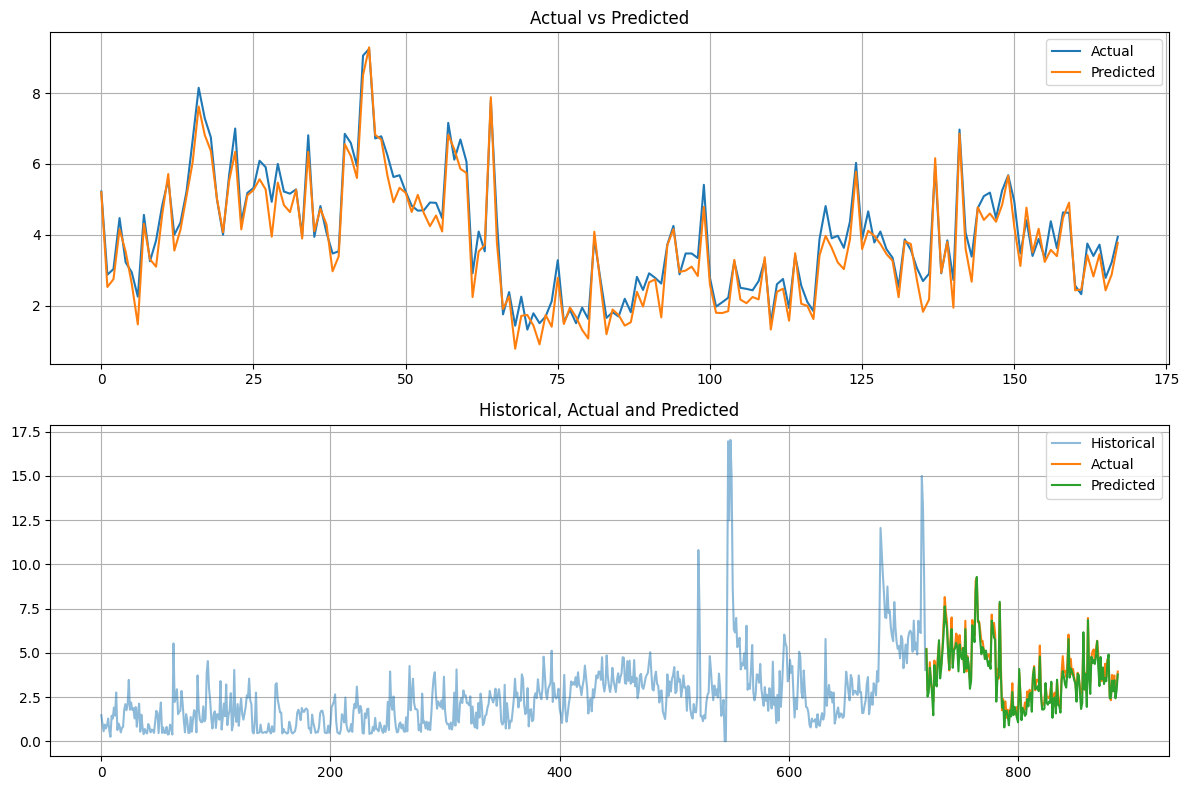


Actual vs Predicted Values:
     Actual  Predicted
0      5.22   5.199522
1      2.87   2.523729
2      3.03   2.743065
3      4.47   4.154521
4      3.22   3.521844
5      2.94   2.620367
6      2.25   1.467724
7      4.56   4.306216
8      3.25   3.306056
9      3.84   3.097411
10     4.82   4.561839
11     5.56   5.714287
12     4.00   3.552242
13     4.34   4.135680
14     5.22   5.084678
15     6.66   6.039459
16     8.15   7.621217
17     7.29   6.814421
18     6.75   6.367776
19     5.00   5.019473
20     4.00   4.069464
21     5.68   5.520723
22     7.00   6.341440
23     4.35   4.150270
24     5.18   5.111948
25     5.32   5.262577
26     6.09   5.567032
27     5.91   5.281819
28     4.93   3.944876
29     6.00   5.472289
30     5.22   4.839226
31     5.16   4.638535
32     5.28   5.269604
33     3.97   3.892629
34     6.81   6.342035
35     3.94   4.099652
36     4.81   4.728996
37     4.06   4.289516
38     3.47   2.966646
39     3.53   3.386912
40     6.85   6.557008
41   

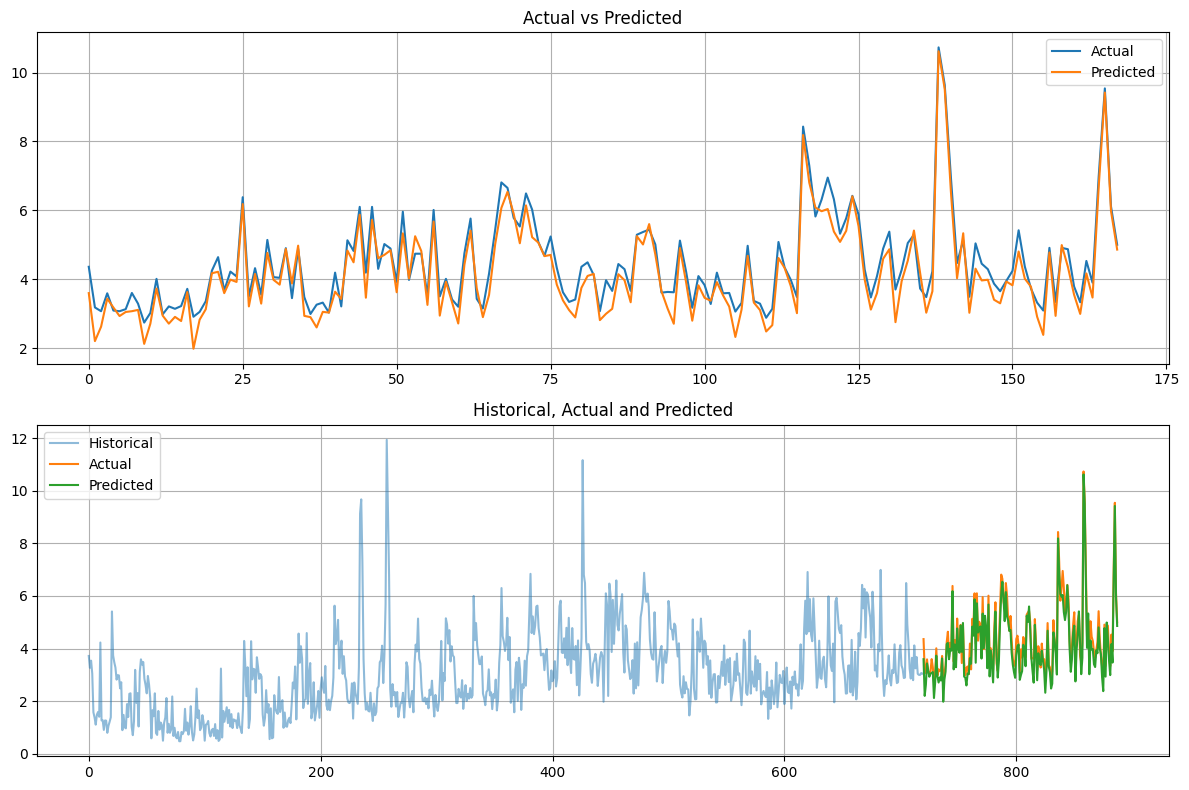


Actual vs Predicted Values:
     Actual  Predicted
0      4.36   3.596087
1      3.18   2.202461
2      3.07   2.620347
3      3.59   3.436070
4      3.09   3.177918
5      3.07   2.930206
6      3.13   3.048200
7      3.60   3.070856
8      3.29   3.108467
9      2.74   2.122003
10     3.02   2.707394
11     4.01   3.730489
12     2.98   2.942873
13     3.21   2.709455
14     3.14   2.905869
15     3.22   2.785379
16     3.72   3.625447
17     2.91   1.981532
18     3.05   2.823009
19     3.36   3.127643
20     4.25   4.173595
21     4.64   4.214879
22     3.67   3.595217
23     4.22   3.987920
24     4.08   3.919829
25     6.38   6.181501
26     3.50   3.210030
27     4.32   4.152739
28     3.55   3.291596
29     5.14   4.764018
30     4.06   3.981629
31     4.04   3.841588
32     4.90   4.879298
33     3.45   3.877194
34     4.88   4.973665
35     3.48   2.935299
36     2.99   2.897673
37     3.26   2.599218
38     3.32   3.051815
39     3.03   3.030307
40     4.19   3.636298
41   

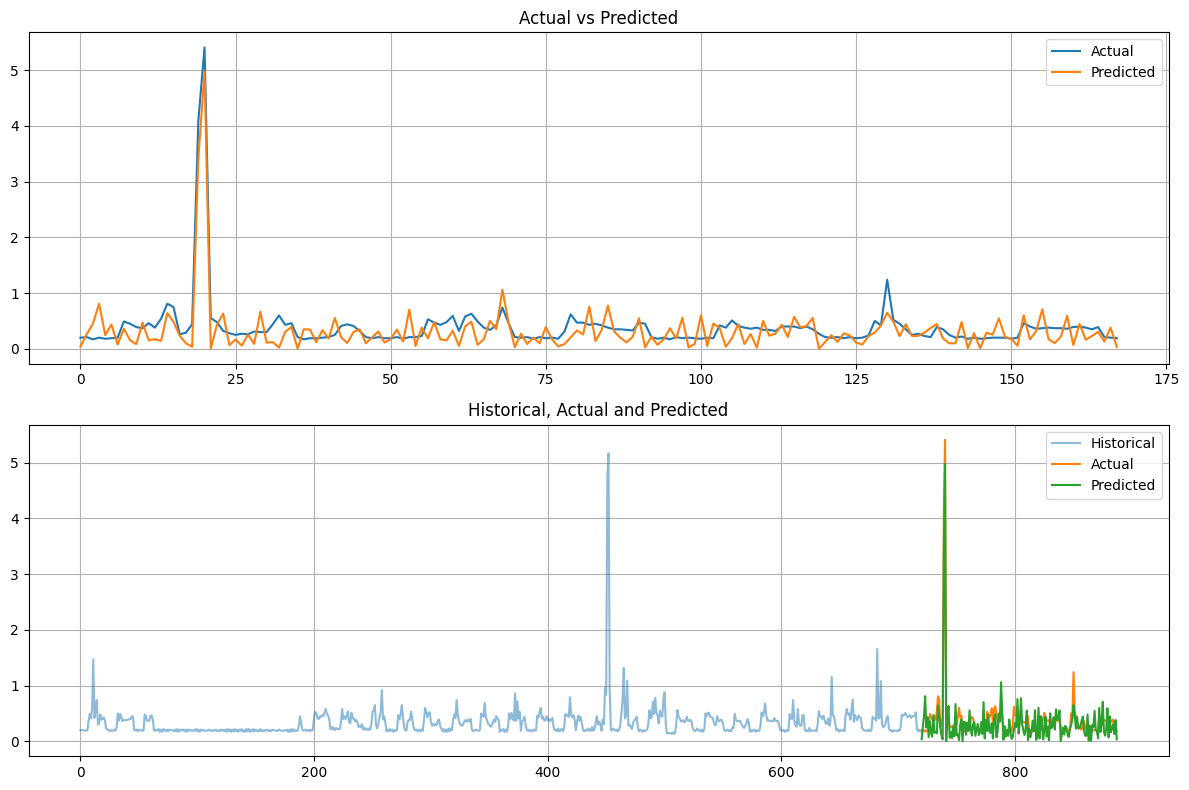


Actual vs Predicted Values:
     Actual  Predicted
0      0.20   0.037763
1      0.21   0.262949
2      0.17   0.446559
3      0.20   0.809118
4      0.18   0.247074
5      0.19   0.435436
6      0.20   0.076677
7      0.49   0.360684
8      0.45   0.155021
9      0.39   0.083585
10     0.37   0.470151
11     0.46   0.153045
12     0.38   0.171893
13     0.54   0.142725
14     0.81   0.641273
15     0.75   0.483886
16     0.26   0.233964
17     0.29   0.099694
18     0.44   0.036977
19     4.09   3.409107
20     5.41   4.978066
21     0.55   0.002041
22     0.48   0.429513
23     0.32   0.633846
24     0.28   0.064020
25     0.25   0.168835
26     0.27   0.056777
27     0.26   0.254534
28     0.31   0.089081
29     0.30   0.667522
30     0.30   0.110161
31     0.44   0.120775
32     0.60   0.021513
33     0.43   0.303459
34     0.46   0.392308
35     0.21   0.001661
36     0.17   0.351991
37     0.19   0.345441
38     0.19   0.117549
39     0.20   0.335280
40     0.21   0.184511
41   

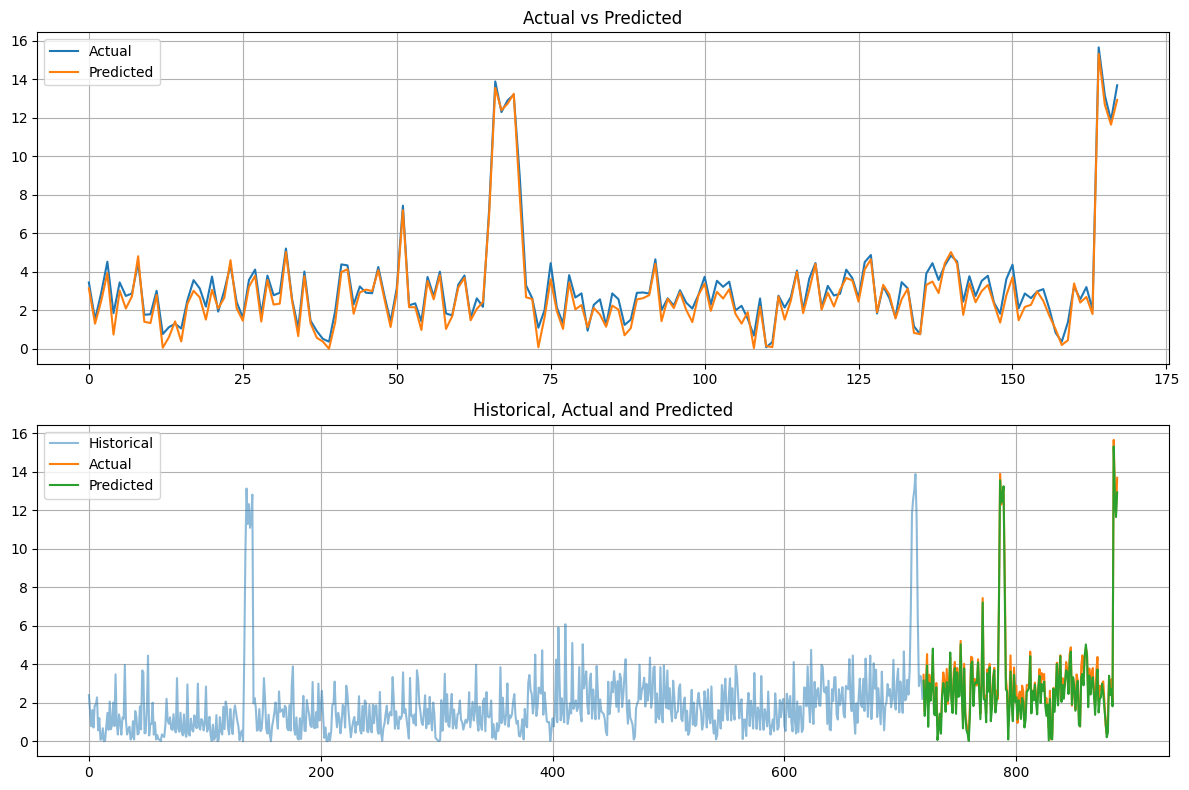


Actual vs Predicted Values:
     Actual  Predicted
0     3.452   3.148951
1     1.538   1.314128
2     2.908   2.489407
3     4.529   3.937230
4     1.859   0.748723
5     3.457   3.030566
6     2.754   2.100917
7     2.885   2.741008
8     4.483   4.815506
9     1.776   1.411188
10    1.802   1.346367
11    3.025   2.802258
12    0.774   0.064498
13    1.132   0.614130
14    1.314   1.433127
15    1.061   0.390566
16    2.532   2.338938
17    3.574   3.019820
18    3.146   2.682027
19    2.202   1.525121
20    3.761   3.073167
21    1.941   2.105709
22    3.049   2.662495
23    4.358   4.611800
24    2.433   2.107351
25    1.629   1.467166
26    3.584   3.229902
27    4.123   3.800252
28    1.794   1.424800
29    3.810   3.583600
30    2.790   2.306109
31    2.919   2.352821
32    5.215   5.036219
33    2.588   2.486603
34    1.090   0.671115
35    4.021   3.779133
36    1.468   1.333867
37    0.936   0.586131
38    0.526   0.383456
39    0.378   0.013624
40    1.967   1.379984
41   

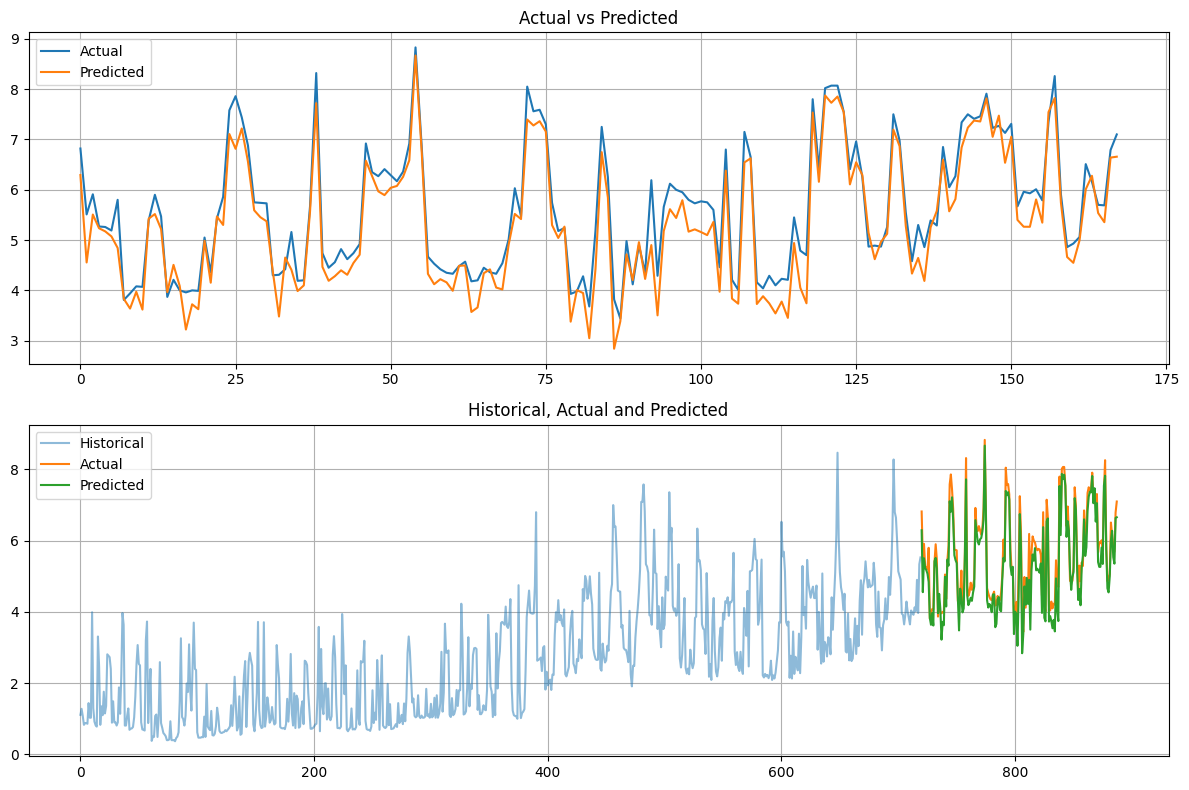


Actual vs Predicted Values:
     Actual  Predicted
0      6.82   6.292692
1      5.51   4.554900
2      5.91   5.507618
3      5.27   5.235116
4      5.26   5.172513
5      5.19   5.072526
6      5.80   4.843328
7      3.81   3.829922
8      3.94   3.638299
9      4.08   3.972040
10     4.07   3.617863
11     5.39   5.425922
12     5.90   5.516978
13     5.47   5.219256
14     3.87   3.965244
15     4.21   4.507104
16     4.00   4.086897
17     3.96   3.221538
18     4.00   3.723067
19     3.99   3.625620
20     5.05   4.986251
21     4.36   4.152844
22     5.43   5.468640
23     5.86   5.300433
24     7.58   7.107332
25     7.86   6.814186
26     7.44   7.218166
27     6.88   6.558153
28     5.75   5.592035
29     5.74   5.454164
30     5.73   5.372997
31     4.30   4.379101
32     4.31   3.480837
33     4.42   4.652395
34     5.16   4.410293
35     4.19   3.986687
36     4.20   4.099225
37     5.67   5.565811
38     8.32   7.721412
39     4.74   4.466512
40     4.45   4.190524
41   

In [ ]:
customer_locs = [
                'Mokki Rautalampi', 
                'kuokkalanpelto', 
                'sarvivuori',
                'kotiranta',
                'Keljo'
                ]
for location in customer_locs:
    print(f"\nProcessing {location}:")
    inference_func(location)